In [1]:
from pycaret.classification import *
from pycaret.classification import load_experiment

In [2]:
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm
tqdm.pandas()

import os
from pprint import pprint
import re
from collections import defaultdict
from util import *

In [3]:
import logging,sys
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - [%(levelname)s] %(filename)s: %(message)s')


In [4]:
from datetime import datetime

print("Begining Time:\n", datetime.now())

Begining Time:
 2024-02-12 16:23:40.723612


In [5]:
DATA_ADDRESS = "./data"
MODEL_DIR = "./model/test_source"
# os.listdir(DATA_ADDRESS)
TRAIN_DIR = os.path.join(DATA_ADDRESS,'preprocessed','train')
TEST_DIR = os.path.join(DATA_ADDRESS,'preprocessed','test')

# os.listdir(TRAIN_DIR)

## Load Data

In [7]:
data_train = load_data(
    dir_feature = TRAIN_DIR,
    file_prefix = 'mfcc_len5_fft2048_mels128_mfcc17_',
    dir_df_index = os.path.join(DATA_ADDRESS,'df_index_train.pkl'),
    n_interval=500,
    flatten=True)

100%|██████████| 100/100 [00:00<00:00, 112.41it/s]
2024-02-12 16:24:02,585 - [DEBUG] util.py: X Shape:(49664, 17, 216)
2024-02-12 16:24:02,618 - [DEBUG] util.py: y Shape:(49664,)
2024-02-12 16:24:02,619 - [DEBUG] util.py: X Shape after flattened:(49664, 3672)
2024-02-12 16:24:02,620 - [INFO] util.py: y has been assigned to column 'target'
2024-02-12 16:24:03,836 - [DEBUG] util.py: final dataframe shape(49664, 3673)


In [8]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,3663,3664,3665,3666,3667,3668,3669,3670,3671,target
0,-80.977600,-80.419434,-79.915077,-79.821449,-79.740036,-79.881989,-80.015327,-80.039238,-80.408401,-80.696159,...,0.789637,0.596668,0.574223,-0.277681,-1.604426,-2.581222,-2.807574,-1.728784,-0.533316,1121.0
1,-75.017464,-71.060478,-65.008240,-60.050758,-56.970104,-56.826725,-58.076405,-61.482307,-66.518311,-72.484703,...,-0.306891,-0.246717,-0.213964,0.116363,0.144263,0.032544,0.068943,0.166217,0.220161,1121.0
2,-83.417419,-83.293800,-83.408394,-83.713020,-83.887047,-83.888329,-83.877029,-83.771271,-83.767853,-83.794540,...,-0.791701,0.350824,0.193292,0.363183,0.191189,0.263955,-0.255743,-0.354151,-0.447814,1121.0
3,-71.465614,-66.708954,-63.589741,-61.603786,-59.245041,-58.487385,-57.167061,-53.935825,-51.339558,-49.302170,...,0.023778,0.023779,0.023779,0.023779,0.023779,0.023779,0.023779,0.023779,0.023779,1121.0
4,-55.037834,-53.793888,-54.851269,-57.155281,-59.371613,-61.002224,-61.387573,-63.297401,-64.819847,-66.793404,...,-1.076139,-0.573394,-0.198749,-0.536650,-0.596209,-0.691602,-1.221938,-1.176664,-1.081235,1121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49659,-61.065483,-61.890282,-66.342545,-69.935310,-71.239807,-66.439484,-58.519917,-53.731632,-53.522854,-54.876545,...,0.023778,0.023779,0.023779,0.023779,0.023779,0.023779,0.023779,0.023779,0.023779,2764.0
49660,-64.618034,-68.115608,-70.921837,-70.175095,-69.387947,-69.356873,-69.167015,-69.488327,-70.192375,-69.982185,...,2.434306,2.909580,2.631790,2.823222,1.799454,1.494457,0.703706,1.029898,1.134758,2764.0
49661,-46.367474,-49.250202,-57.679966,-59.765530,-60.607216,-62.105274,-64.704330,-67.527321,-69.604301,-71.893944,...,-0.118366,0.212306,0.440332,0.264980,-0.524699,-0.728151,-0.329682,0.371225,0.697577,2764.0
49662,-74.254692,-75.630730,-77.319359,-77.614624,-77.739082,-78.626854,-79.749619,-80.394928,-81.047089,-81.700462,...,-0.737201,-0.468647,-0.505667,-0.339689,0.402360,1.382017,1.872381,1.860687,1.271469,2764.0


## Load Model

In [9]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.WARNING)


In [10]:
# load_experiment("model/test_source/experiment_1707607588",data)

In [15]:
# logistic regression
clf_lr = load_model("model/test_source/dis_first_1000/test_source_0")
# extra tree
clf_et = load_model("model/test_source/dis_first_1000/test_source_1")

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [16]:
clf_lr

Pipeline(memory=FastMemory(location=C:\Users\bobmst\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['0', '1', '2', '3', '4', '5', '6',
                                             '7', '8', '9', '10', '11', '12',
                                             '13', '14', '15', '16', '17', '18',
                                             '19', '20', '21'...
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='most_frequent',
                                                              verbose='deprecated'))),
                ('trained_model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

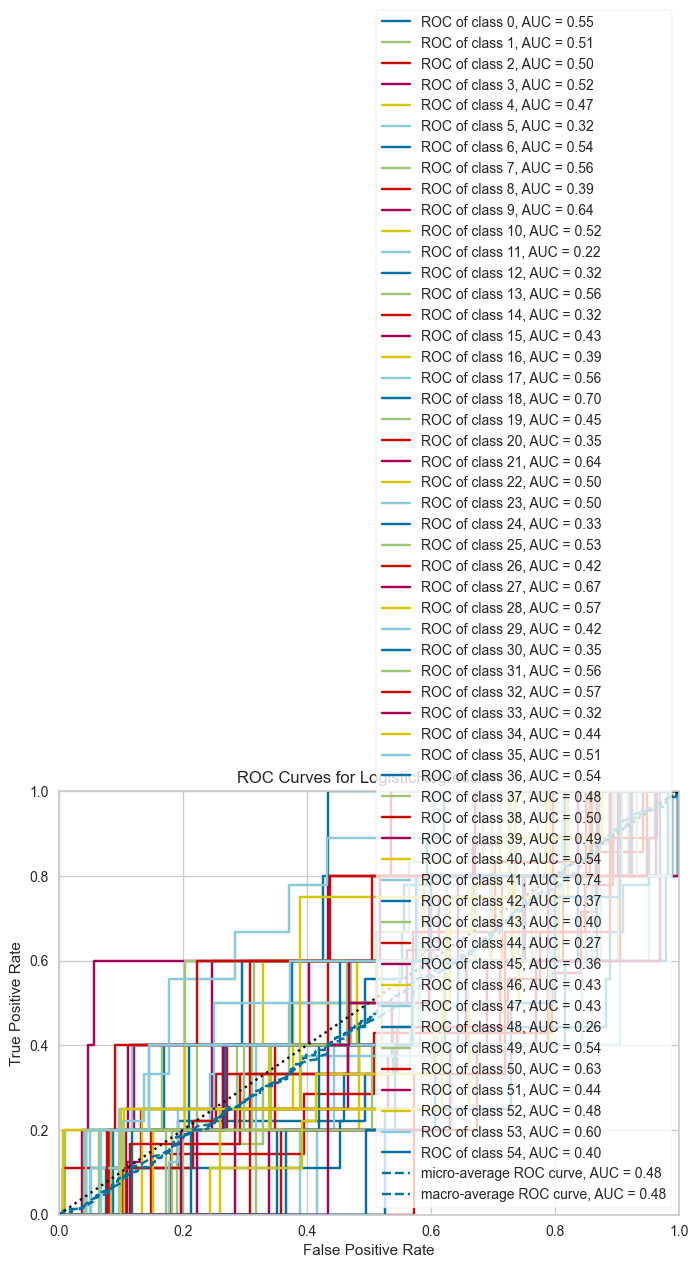

In [18]:
plot_model(clf_lr, plot = 'auc')

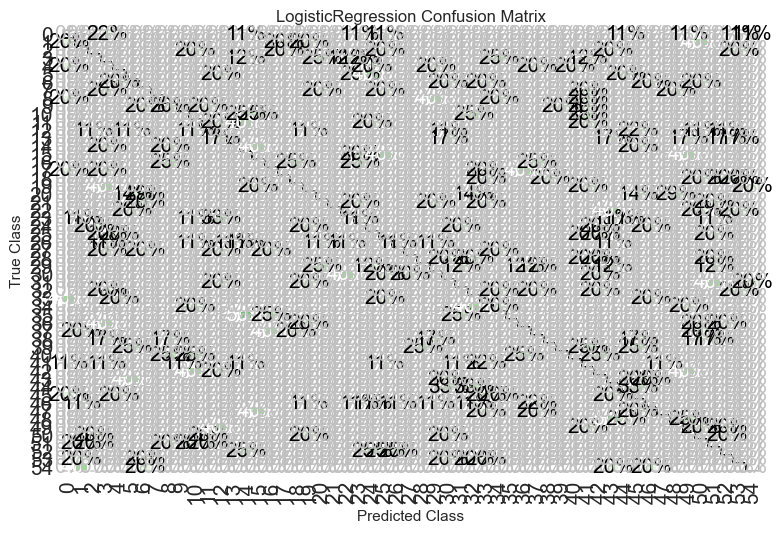

In [20]:
plot_model(clf_lr, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

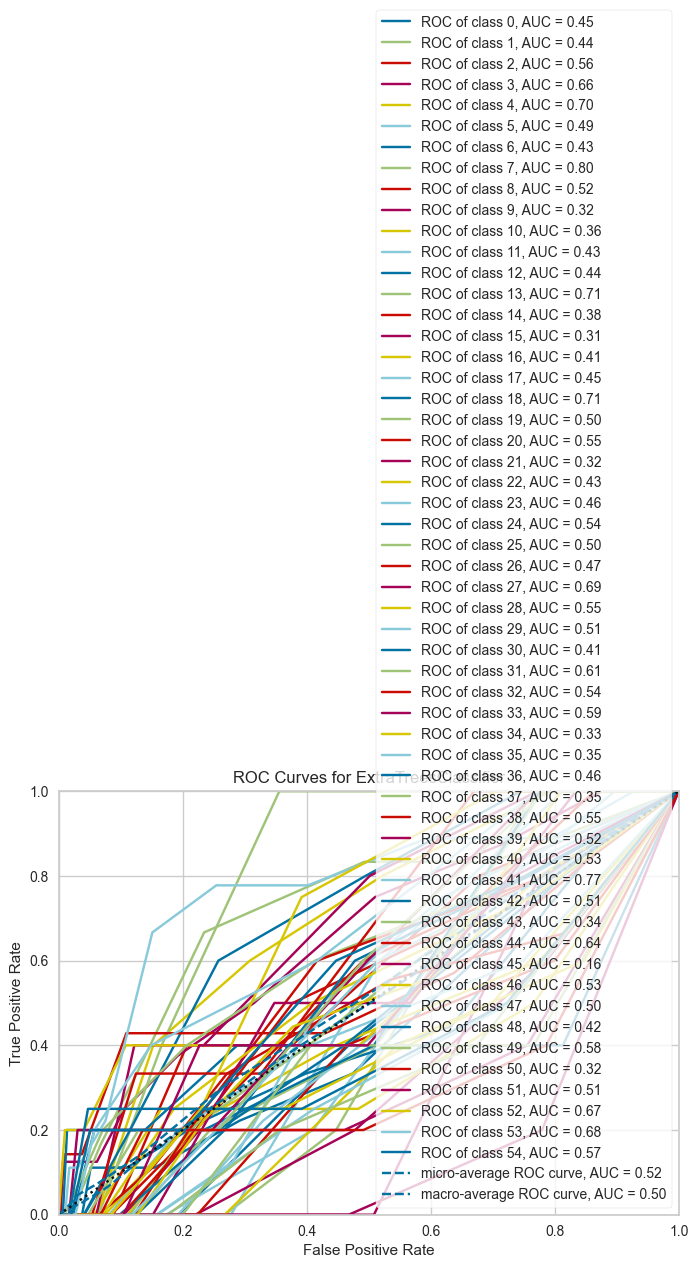

In [19]:
plot_model(clf_et, plot = 'auc')